# SNe "Simulations" from NIR data

In [1]:
import snpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNooPy version: v2.6.0


### Auxiliar Functions
The *permutations* and *combination* functions below were taken from [this link](https://www.codegrepper.com/code-examples/python/python+permutation)

In [2]:
def permutations(iterable, r=None):
    '''Returns all possible permutations.
    
    Parameters
    ==========
    iterable: list-like
        List of items from which the permutation is computed.
    r: int, default `None`
        Numbers of items for the permutation.
        
    Returns
    =======
    All permutations.
    
    Examples:
    permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    permutations(range(3)) --> 012 021 102 120 201 210
    '''
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return
        
def combinations(iterable, r):
    '''Returns all possible combinations without repetition.
    
    **Note:** the output should be inserted in a list
    
    Parameters
    ==========
    iterable: list-like
        List of items from which the combination is computed.
    r: int
        Numbers of items for the combination.
        
    Returns
    =======
    Generator with all combinations.
    '''
    pool = tuple(iterable)
    n = len(pool)
    for indices in permutations(range(n), r):
        if sorted(indices) == list(indices):
            yield tuple(pool[i] for i in indices)
            
def mag2flux(mag, zp, mag_err=0.0):
    """Converts magnitudes to fluxes, propagating errors if given.
    
    Parameters
    ----------
    mag : array
        Array of magnitudes.
    zp : float or array
        Zero points.
    mag_err : array, default ``0.0``
        Array of magnitude errors.
        
    Returns
    -------
    flux : array
        Magnitudes converted to fluxes.
    flux_err : array
        Magnitude errors converted to errors in fluxes.
    """

    flux = 10**( -0.4*(mag-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*mag_err )

    return flux, flux_err

### "Simulations" functions

In [5]:
def filter_coeval_NIRdata(sn):
    """Filters out NIR data of a SNooPy object that does not have 
    coeval J/Jrc2 and H data.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    The updated sn.
    """
    
    # NIR bands labels
    nir_bands = [band for band in sn.allbands() if band in ['J', 'Jrc2', 'H']]
    nir_ebands = [f'e_{band}' for band in nir_bands]  # for errors

    # Find epochs with coeval J and H bands
    # I HAVE TO THINK ON HOW THIS AFFECTS SNe WITH J AND Jrc2 DATA
    sn_df = pd.DataFrame(sn.get_mag_table())
    sn_df.replace(99.900000, np.nan, inplace=True)
    sn_df = sn_df[['MJD'] + nir_bands + nir_ebands].dropna()
    
    # update SN J and H bands data
    for band, eband in zip(nir_bands, nir_ebands):

        mjd = sn_df['MJD'].values
        mag, mag_err = sn_df[band].values, sn_df[eband].values
        
        sn.data[band].MJD = mjd
        sn.data[band].magnitude = mag
        sn.data[band].mag = mag
        sn.data[band].e_mag = mag_err

        zp = sn.data[band].filter.zp
        flux, flux_err = mag2flux(mag, zp, mag_err)

        # there are some hidden parameters like "_flux" and "_eflux"
        # which are used by other internal functions
        sn.data[band].flux = flux
        sn.data[band]._flux = flux
        sn.data[band].e_flux = flux_err
        sn.data[band]._eflux = flux_err

        # not sure if these are completely necessary, but just in case...
        sn.data[band].sids = np.zeros_like(flux)
        sn.data[band].__dict__['mask'] = np.array([True]*len(flux))
        
    return sn

def alternate_values(values, n_epochs):
    """Extracts a list of all the combinatories of `values` with 
    `n_epochs` number of items each.
    
    Parameters
    ==========
    values: list-like
        List of values from which the combinatories are extracted.
    n_epochs: int
        Number of items per combinatory.
        
    Returns
    =======
    list_alt_values: list
        List of all the combinatories, where each combinatory is a numpy array.
    """
    
    len_values = len(values)
    
    alt_values_tuples = list(combinations(values, n_epochs))
    list_alt_values = [np.array(tup) for tup in alt_values_tuples]

    return list_alt_values

def extract_combinatory(sn, n_epochs):
    """Extracts a dictionary with all the combinatories of `mjd`, `mag` and `mag_err`
    for a SN in J/Jrc2 and H bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
        
    Returns
    =======
    values_dict: dict
        Dictionary with the NIR bands as keys and sub-dictionaries as values.
        Each sub-dictionary has `mjd`, `mag` and `mag_err` as keys and a list
        of combinatories (the results of `alternate_values()`) as values.
    """
    
    # NIR bands labels
    nir_bands = [band for band in sn.allbands() if band in ['J', 'Jrc2', 'H']]
    nir_ebands = [f'e_{band}' for band in nir_bands]  # for errors

    values_dict = {band:None for band in nir_bands}
    # update SN J and H bands data
    for band, eband in zip(nir_bands, nir_ebands):

        mjd = sn.data[band].MJD.copy()
        mag = sn.data[band].magnitude.copy()
        mag_err = sn.data[band].e_mag.copy()
        
        mjd_list = alternate_values(mjd, n_epochs)
        mag_list = alternate_values(mag, n_epochs)
        mag_err_list = alternate_values(mag_err, n_epochs)
        
        values_dict[band] = {'mjd':mjd_list, 'mag':mag_list, 'mag_err':mag_err_list}
        
    return values_dict

def calculate_metrics(sn, NIR_band, n_epochs):
    """Calculates the metrics for the NIR bands of a SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    NIR_band: str
        NIR bands. E.g., `J`, `Jrc2` or `H`.
    n_epochs: int
        Number of epochs per NIR band.
        
    Returns
    =======
    m1, m2, m3: ints
        Metrics:- m1 is the phase of the closest epoch to T.max.
                - m2 is the phase of the phases.
                - m3 is the difference between the first and last epoch.
        **Note:** m2 is only calculated if n_epochs >= 2, and m3 if n_epochs == 3.
    """

    assert n_epochs<=3, 'Metrics are only calculated for `n_epochs` <= 3'
    phases = sn.data[NIR_band].MJD - sn.Tmax

    if n_epochs==1:
        m1 = phases[0]
        return m1

    elif n_epochs==2:
        m1_ind = np.argmin(np.abs(phases))
        m1 = phases[m1_ind]
        
        m2 = np.mean(phases)
        return m1, m2

    elif n_epochs==3:
        m1_ind = np.argmin(np.abs(phases))
        m1 = phases[m1_ind]

        m2 = np.mean(phases)
        m3 = phases[-1] - phases[0]
        return m1, m2, m3
    
def fit_combinatory(sn, n_epochs):
    """Fit a SN multiple times for all the combinatories given by `n_epochs`.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
    """
    
    sn = filter_coeval_NIRdata(sn)
    values_dict = extract_combinatory(sn, n_epochs)
    
    NIR_band = list(values_dict.keys())[0]
    num_comb = len(values_dict[NIR_band]['mjd'])
    
    for i in range(num_comb):
        
        for band in values_dict.keys():
            band_info = values_dict[band]
            
            mjd = band_info['mjd'][i]
            mag = band_info['mag'][i]
            mag_err = band_info['mag_err'][i]
            
            sn.data[band].MJD = mjd
            sn.data[band].magnitude = mag
            sn.data[band].mag = mag
            sn.data[band].e_mag = mag_err

            zp = sn.data[band].filter.zp
            flux, flux_err = mag2flux(mag, zp, mag_err)

            # there are some hidden parameters like "_flux" and "_eflux"
            # which are used by other internal functions
            sn.data[band].flux = flux
            sn.data[band]._flux = flux
            sn.data[band].e_flux = flux_err
            sn.data[band]._eflux = flux_err

            # not sure if these are completely necessary, but just in case...
            sn.data[band].sids = np.zeros_like(flux)
            sn.data[band].__dict__['mask'] = np.array([True]*len(flux))
            
        try:
            sn.choose_model('max_model', stype='dm15')
            sn.fit()
            
            # save results
            #sn.save()
            # save metrics
            metrics = calculate_metrics(sn, NIR_band, n_epochs)
        except:
            print(f'Combinatory number {i} failed for {sn.name}!')

CPU times: user 157 ms, sys: 5.83 ms, total: 163 ms
Wall time: 1.41 s
CPU times: user 4min 20s, sys: 3min 9s, total: 7min 29s
Wall time: 1min 47s


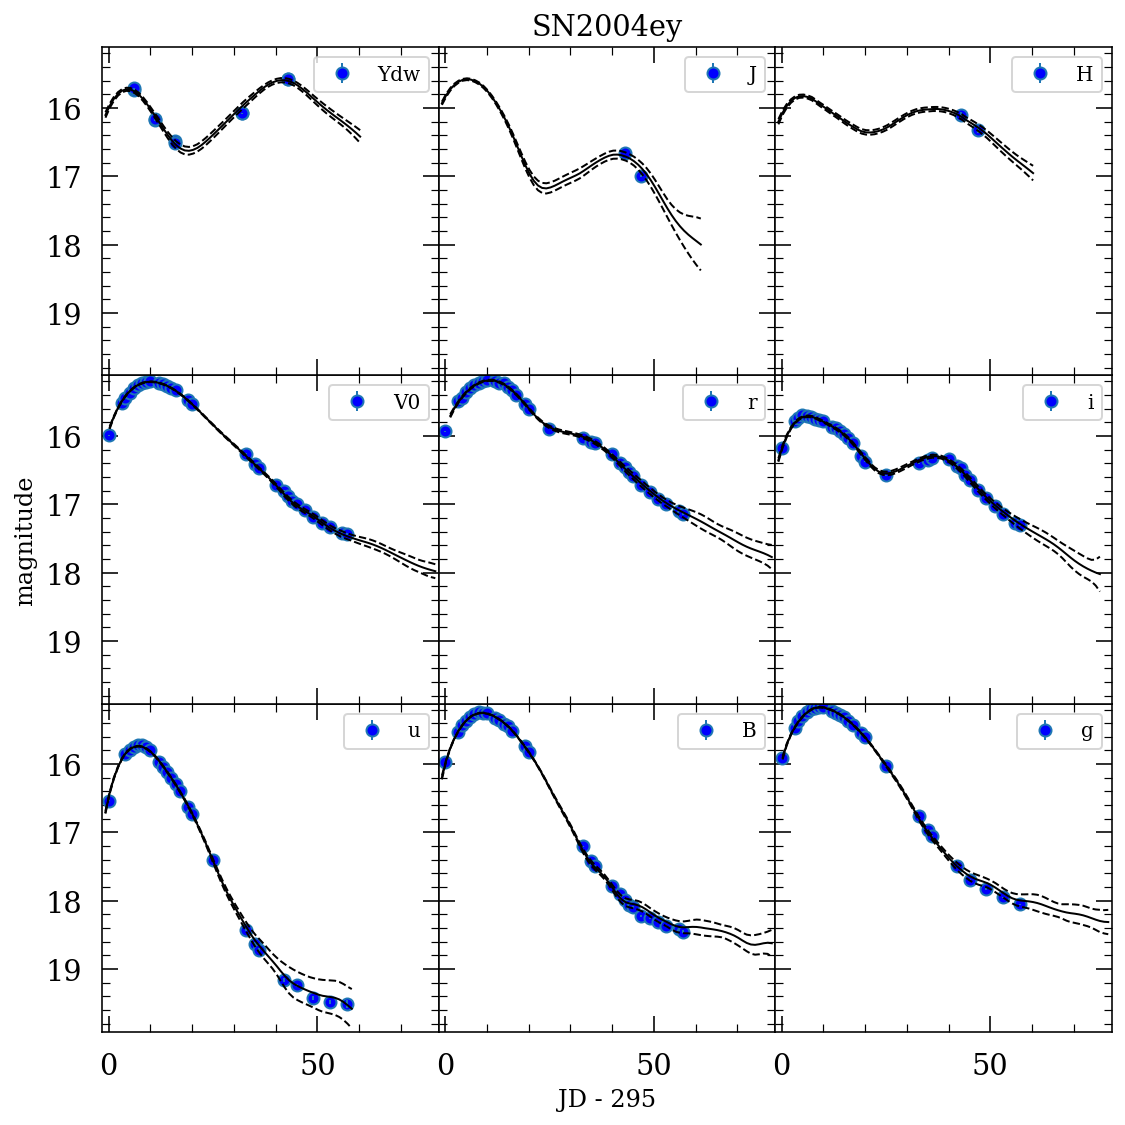

In [10]:
n_epochs = 2

sn_file = os.path.join('csp_dr3', 'SN2004ey_snpy.txt')
%time sn = snpy.import_lc(sn_file)

%time fit_combinatory(sn, n_epochs)